# Review of classification techniques

## What we will accomplish

In this notebook we will:
- Review all of our classification techniques
- Apply them all to a new "toy" dataset
- Look at the decision boundaries when we train them on only 2 features
- Discuss the results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Wine dataset comes with sklearn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# Importing all of the classifiers we learned about
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Some of these need scaling first to work well 
# We will also see how polynomial features can give us nonlinear decision boundaries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# We will just use accuracy score for model comparison
from sklearn.metrics import accuracy_score


In [2]:
X, y = load_wine(return_X_y = True, as_frame = True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle = True, random_state=216, stratify=y)

In [4]:
X_train

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
106,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0
107,12.72,1.75,2.28,22.5,84.0,1.38,1.76,0.48,1.63,3.30,0.88,2.42,488.0
162,12.85,3.27,2.58,22.0,106.0,1.65,0.60,0.60,0.96,5.58,0.87,2.11,570.0
17,13.83,1.57,2.62,20.0,115.0,2.95,3.40,0.40,1.72,6.60,1.13,2.57,1130.0
82,12.08,1.13,2.51,24.0,78.0,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0
54,13.74,1.67,2.25,16.4,118.0,2.60,2.90,0.21,1.62,5.85,0.92,3.20,1060.0
126,12.43,1.53,2.29,21.5,86.0,2.74,3.15,0.39,1.77,3.94,0.69,2.84,352.0
33,13.76,1.53,2.70,19.5,132.0,2.95,2.74,0.50,1.35,5.40,1.25,3.00,1235.0


In [5]:
classifiers = {
    'knn' : Pipeline([('scale', StandardScaler()),('knn', KNeighborsClassifier())]),   
    'lda' : LinearDiscriminantAnalysis(),
    'lda_quadratic' : Pipeline([('scale', StandardScaler()),('poly',PolynomialFeatures(2)),('lda', LinearDiscriminantAnalysis())]),
    'qda' : QuadraticDiscriminantAnalysis(),
    'gnb' : GaussianNB(),
    'log_reg' : Pipeline([('scale', StandardScaler()),('log_reg', LogisticRegression(multi_class = 'multinomial'))]),
    'log_reg_poly' : Pipeline([('scale', StandardScaler()),('poly',PolynomialFeatures(2)),('log_reg', LogisticRegression(multi_class = 'multinomial'))]),
    'svc_linear' : LinearSVC(dual = 'auto'),
    'svc_rbf' : SVC(kernel= 'rbf')
}

In [6]:
for model_name, model in classifiers.items():
    model.fit(X_train,y_train)

accs = {model_name: accuracy_score(y_test, model.predict(X_test)) for model_name, model in classifiers.items()}

accs

{'knn': 0.9444444444444444,
 'lda': 0.9722222222222222,
 'lda_quadratic': 0.9722222222222222,
 'qda': 1.0,
 'gnb': 0.9444444444444444,
 'log_reg': 1.0,
 'log_reg_poly': 1.0,
 'svc_linear': 0.9444444444444444,
 'svc_rbf': 0.6666666666666666}

This is great!  

It looks like the classes are linearly seperable, so we see all of the models which have linear decision boundaries doing better.

Note that if we had run logistic regression without regularization (`penalty = None`) we would get a warning about convergence.  Logistic regression has model parameters which diverge in the case of perfect seperation.

It is interesting that Support Vector Machines with radial basis function (`rbf`) kernal does so poorly.  This is probably a hyperparameter tuning problem.  The value of `gamma` is the inverse of the standard deviation of the gaussian used.  A large value of `gamma` corresponds to a small variance, which in turn controls how much we weight the class of nearby samples.  A larger `gamma` is conceptually similar to a smaller value of $k$ in kNN.



We now train the same models on only the first two features so we can visualize what is going on.

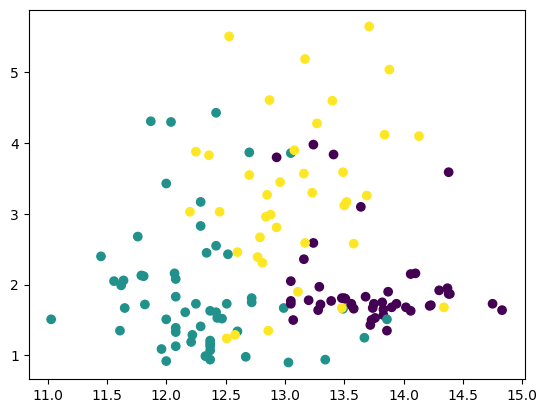

In [7]:
plt.scatter(X_train['alcohol'], X_train['malic_acid'], c = y_train)
plt.show()

As we can see the classes are not perfectly seperated in this projection, so we should expect worse accuracy.

In [8]:
for model_name, model in classifiers.items():
    model.fit(X_train[['alcohol','malic_acid']],y_train)

test_accs = {model_name: accuracy_score(y_test, model.predict(X_test[['alcohol','malic_acid']])) for model_name, model in classifiers.items()}

test_accs

{'knn': 0.7777777777777778,
 'lda': 0.75,
 'lda_quadratic': 0.7777777777777778,
 'qda': 0.75,
 'gnb': 0.7777777777777778,
 'log_reg': 0.7777777777777778,
 'log_reg_poly': 0.75,
 'svc_linear': 0.6944444444444444,
 'svc_rbf': 0.75}

Interestingly the RBF kernel improved, and is now performing comparably to the other models!

We now plot all of the decision boundaries.

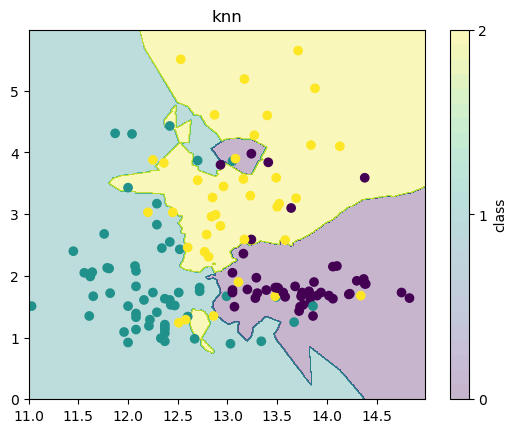

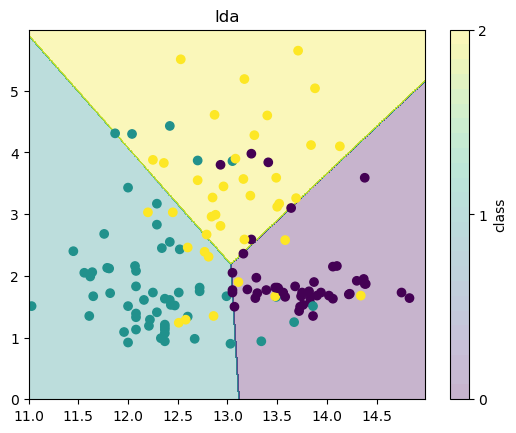

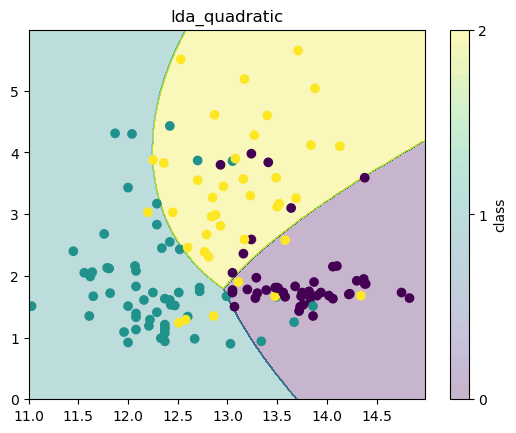

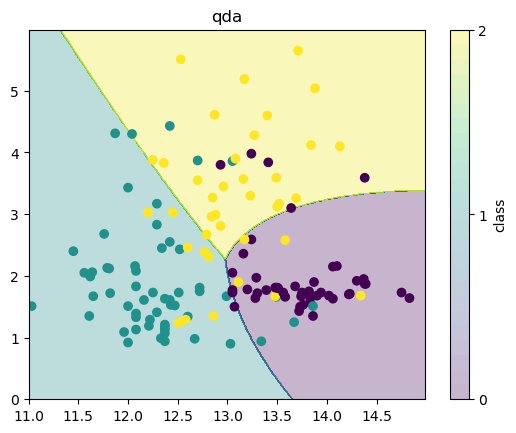

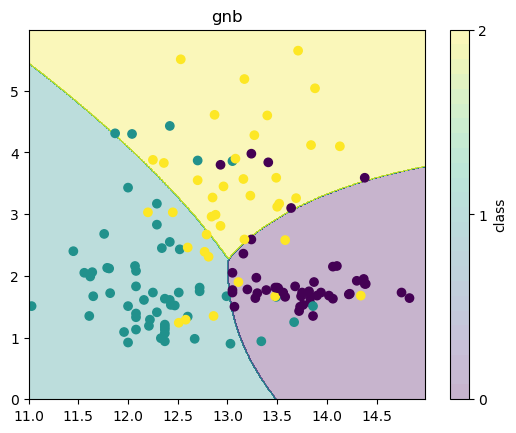

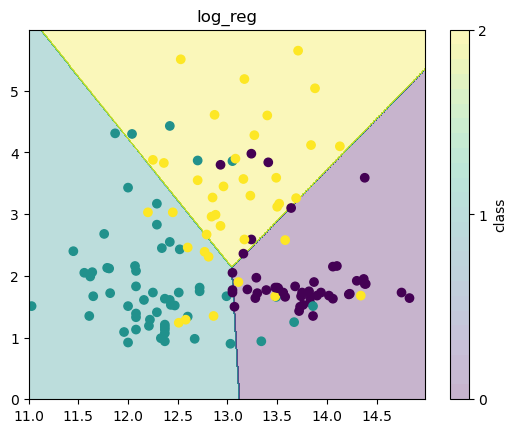

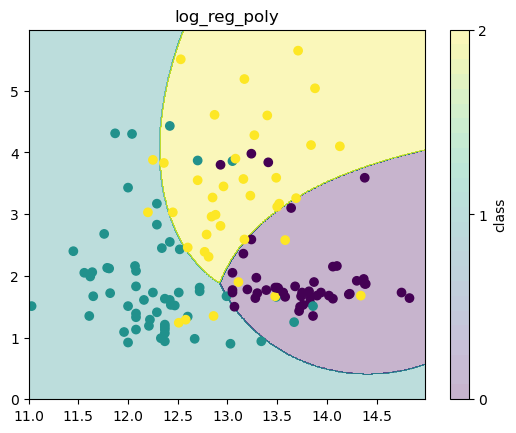

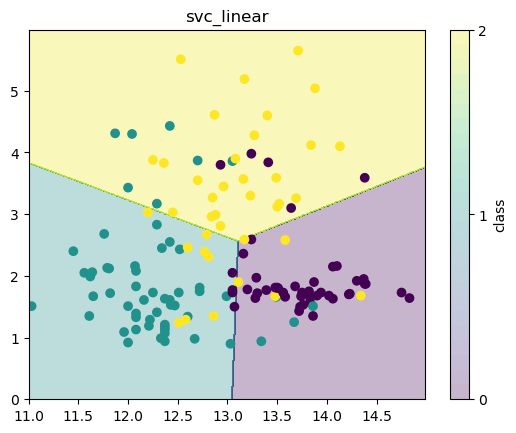

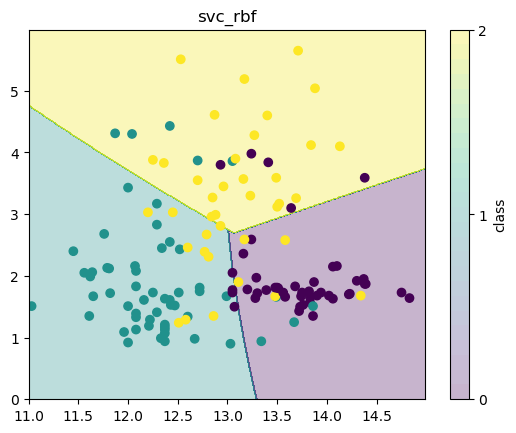

In [9]:
xx, yy = np.mgrid[11:15:.01, 0:6:.01]

grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['alcohol','malic_acid'])

for model_name, model in classifiers.items():
    preds = model.predict(grid).reshape(xx.shape)

    contour = plt.contourf(xx, yy, preds, 25, alpha = 0.3,
                      vmin=0, vmax=2)
    ax_c = plt.colorbar(contour)
    ax_c.set_label("class")
    ax_c.set_ticks([0, 1, 2])

    plt.scatter(X_train['alcohol'], X_train['malic_acid'], c = y_train)
    plt.title(model_name)
    
    plt.show()
    

A few observations:

* kNN can have complex boundaries.  This is a plus if your data really is that complex, but it isn't helping us here.  kNN can be prone to overfitting.
* All of the classifiers with linear decision boundaries (LDA, logistic regression, linear SVC) are giving us extremely similar decision boundaries.
* I showcased how transforming the features with nonlinear transformations can give us non-linear boundaries even using logistic regression and LDA.

--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.